# TDA Analysis
#### Introduction

In this script, we will use the selected parameters to run kmapper on the entire cleaned LTRM data. Our parameters are epsilon 1, min_samples 20, n_cubes 125, and perc_overlap .4. We will create the simplicial complex, find the states, and then color the html file by various variables.

Recall the heuristics we used for parameter selection:

1. Each cluster has at most 10% of the data
2. The Mapper output represents at least 90% of the data (no more than 10% of the original data, aka 7600 data points, are lost as noise).

#### Outline

This notebook will first make the following alterations to the cleaned and interpolated LTRM data:

1. Scale the conintuous variable columns with RobustScaler(). Robust scaler scales the data by subtracting the median and dividing by the IQR for each continuous variable.
2. Adding 5 decade columns with one-hot encoding
3. Adding 3 stratum columns with one-hot encoding
4. Adding 6 field number columns with one-hot encoding
5. New coloring columns for each continuous variable with a lower 'ceiling'
6. 10 new unscaled continuous variable columns 


We will then run kmapper with several different combinations of parameter values (epsilon, min samples, cubes, and percent overlap). Recall that we are using PCA 2 as the filter function. We will use the heuristics stated previously to choose a combination of parameters. 

The TDA analysis will include the following steps:

1. Run kmapper on the data set
2. Use the code written by Killan to find the density of each node in a simplicial complex
3. Convert the simplicial complex to a directed graph with arrows pointing to a node with a higher density
4. Local maxium will be defined as sinks of the directed graph
5. States of a local maximum will be made up of the nodes who shorted graph distance to a local maximum is that local maximum
6. Color the simplicial complex by different variables to make inferences about the states in each region of the river
7. Make boxplots of the continuous variables for each state


## Import libraries

In [53]:
import kmapper as km
from kmapper.plotlyviz import *
import pandas as pd
import numpy as np

import sklearn
#from sklearn import ensemble
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
# from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# scipy for interpolation
# import scipy 
# from scipy.interpolate import *
import hdbscan
import pickle as pk
import json as js
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Plotly and Dash
import plotly.graph_objs as go
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
from ipywidgets import (HBox, VBox)
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")

## Upload data

In [ ]:
# Use this if using a pickle file with the scomplex already created
dataFilePath = "LTRM_df.p"
df = pk.load(open(dataFilePath, "rb"))['LTRM']

In [65]:
water20 = pd.read_csv("../../../../LTRM data/RF interpolation/water_full.csv")
water20 = water20[["SHEETBAR", "DATE", "LATITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
"TN","TP","TEMP", "DO", "TURB", "VEL", "SS", "WDP", "CHLcal",  "SECCHI", "YEAR", "SEASON"]]

## Scale data

We will be using RobustScaler() to scale our data. For each continuous variable column RobustScaler will subtract the median of the column from every observation and divide by the IQR. We will be using RobustScaler instead of StandardScaler because it is robust to outliers. It is important that we scale our data so that every variable has equal opportunity to be significant in our principal components.

In [66]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

ct = ColumnTransformer([('somename', RobustScaler(), continuous_variables)], remainder = 'passthrough')

water_df = ct.fit_transform(water20)

water_df = pd.DataFrame(water_df, columns = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal",
                                             "SHEETBAR", "DATE", "LATTITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
                                             "YEAR", "SEASON"])  

## Make new columns with one-hot encoding

In order to color the scomplex by categorical variables, we need to make dummy columns for the selected variables. A dummy column is a column that is filled with 1's and 0's depending on whether an observation meets a certain condition. In this case the conditions will be whether or a not an observations was taken in a year intercal, whether an observation belongs in a specific stratum, or whether and observations belongs in a specific pool.

### Make decade columns


In [67]:
eco_time_periods = ['1993-2000', '1898-2004', '2001-2013', '2010-2016', '2014-2020']

for time_period in eco_time_periods:
    begin_year = int(time_period[0:4])
    end_year = int(time_period[5:9])
    
    water_df[time_period] = np.where((water_df['YEAR'] >= begin_year) & (water_df['YEAR'] <= end_year), 1, 0)

### Make STRATUM and FLDNUM columns

In [68]:
to_dummy_vars = ['STRATUM', 'FLDNUM']

for var in to_dummy_vars:
    temp = pd.get_dummies(water_df[var])
    water_df = pd.concat([water_df, temp], axis = 1)

### Make unscaled columns

To get the unscaled columns, we will manually reverse the RobustScaler by multiplying each column values by the columns IQR and adding its median.


In [69]:
for variable in continuous_variables:
    column_name = variable + "_unscaled"
    median = water20[variable].median()
    q25 = water20[variable].quantile(.25)
    q75 = water20[variable].quantile(.75)
    iqr = q75 - q25

    water_df[column_name] = water_df[variable].apply(lambda x: (x * iqr) + median)

## Make coloring columns for continuous variables

Since the LTRM data has so many outliers for each continous variable, the color scale for the html is skewed strongly to the right. Kmapper uses min-max color scaling meaning that the smallest value is set to the left of the scale and the largest values is set to the right of the color scale. With so many large outliers, most of the nodes are colored by the left side of the scale and thus qualitative information from coloring is lost. For examples, since there are such extreme outliers in the TN columns, the html is colored all dark purple - the low level of the scale. With this the case, it is difficult to see where the larger values of TN are in the simplicial complex. In attempt to minimize the skewedness, we will be creating new columns in which the outlier values are lowered. This will "lower the ceiling" of the continuous variables and allow us better distinguish differences in continuous variables across the simplicial complex.

We will be setting our ceiling to the Q75 + (3 * IQR) whereas an outlier is defined by Q75 + (1.5 * IQR). This will ensure that our extreme outliers will still be regarded as outliers, though they will not disrupt the information we can gain from the various coloring values. NOTE that this change is made souly for coloring and will not be used when we calculate statisitcal information for each state.

NOTE: The alter coloring columns use the scaled data.

In [70]:
for variable in continuous_variables:
    column_name =  variable + "_color" 

    q25, q75 = np.percentile(water_df[variable], [25, 75])
    iqr = q75 - q25

    ceiling = water_df[variable].quantile(.75) + (3 * iqr)

    water_df[column_name] = np.where(water_df[variable] >= ceiling, ceiling, water_df[variable])

# Run kmapper

## Make the kmapper scomplex

In [71]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
X = water_df

var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
projected_var_indices = [var_to_index[var] for var in continuous_variables]

X.reset_index(drop = True, inplace = True)

cluster_alg = sklearn.cluster.DBSCAN(eps = 1, min_samples = 20, metric = 'euclidean')
#cluster_alg = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 10)
pca = PCA(n_components = 2)
lens = pca.fit_transform(X[continuous_variables])

mapper = km.KeplerMapper(verbose = 0)
scomplex = mapper.map(lens, X[continuous_variables], cover = km.Cover(n_cubes = [125, 125], perc_overlap = [.4, .4]), 
                                            clusterer = cluster_alg, remove_duplicate_nodes = True)


## Determine states in the simplicial complex

Recal our method for defining a state in the mapper output:

1. Calculate the density of each node in a simplicial complex
2. Create a directed graph by converting each edge in the simplicial complex to an arrow pointing in the direction of greater density
3. Find the local maxima - the nodes that all other nodes go towards
4. Assign a node to the state associated with the closest local maxima

#### Functions written by Forrest and Killain

In [76]:
from sklearn.neighbors import NearestNeighbors
import queue
import networkx as nx

In [77]:
def getSubdf(scomplex, shape, df):
    """
    Returns the part of the data frame from the particular shape in the simplicial complex.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex)
    df: the entire data frame
    
    Description:
    1. Get all the nodes from the particular simplicial complex. 
    2. Generate the indices we care about from the particular shape. To do this, we read each node and append it's 
    indices to a list. Then, we convert the list to a set and then back to a list to eliminate duplicates.
    3. Return the dataframe with only those indices.
    """
    
    nodes = scomplex.get('nodes')
    indices = []
    npShape = np.array(shape).flatten()
    for node in npShape:
        indices.append(nodes.get(node))
    indices = list(set([item for sublist in indices for item in sublist]))
    subdf = df.loc[indices]
    return subdf

def adjacent(v, scomplex):
    """
    Determines the nodes adjacent to a given vertex
    
    params:
    v: vertex
    scomlex: the entire simplicial complex
    
    Description:
    Determines the nodes that are adjacent to a given vertex.
    """
    
    simplices = scomplex.get('simplices')
    edges = [item for item in simplices if len(item) == 2]
    result = []
    for edge in edges:
        if v in edge:
            for item in edge:
                if item != v:
                    result.append(item)
    return result

def bfs(node, scomplex):
    """
    Conducts a breadth first search to obtain the entire shape from a given node
    params:
    node: the start node
    scomplex: the entire simplicial complex
    
    Description:
    Preforms a breadth first search to obtain the entire shape for a given start node.
    """
    Q = queue.Queue()
    result = []
    result.append(node)
    Q.put(node)
    while not Q.empty():
        v = Q.get()
        adjacentEdges = adjacent(v, scomplex)
        for edge in adjacentEdges:
            if edge not in result:
                result.append(edge)
                Q.put(edge)
    return result

def getShapes(scomplex):
    """
    Gets all of the shapes from a given simplicial complex.
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Obtain all the nodes for the entire complex
    2. For each node, preform a breadth first search to obtain everything in that particular shape. 
    If this entire shape has not already been discovered, add it to the set of results. 
    The result item is a set as the order of the shapes does not matter. The resulting shape is a frozenset
    which means items cannot be added or removed once created, and is needed to allow the set object to have other sets within it.
    3. Convert each shape to a list and the result to a list for easier navigation outside of the function.
    4. Return the result
    
    """
    
    nodes = list(scomplex.get('nodes').keys())
    result = set()
    for node in nodes: # currently does more computations than necessary due to going through every node without considering it is already in a shape
        bfsResult = frozenset(bfs(node, scomplex))
        result.add(bfsResult)
    result = [list(x) for x in result]
    # Sort the list depending on what is decided: nodes or indices. Currently doing it by number of nodes
    result.sort(key = len, reverse = True)
    
    
    
    return result

def condenseShape(shape, scomplex):
    """
    
    params:
    shape: a shape of two nodes. must be 2
    scomplex: the entire simplicial complex
    
    description:
    gets the two nodes a and b
    gets the indices for a and b (what is inside the nodes)
    if a \subseteq b, return b
    elif b \subseteq a, return a 
    else return shape 
    
    """
    nodes = scomplex.get('nodes')
    a = shape[0]
    b = shape[1]
    aIndices = set(nodes.get(a))
    bIndices = set(nodes.get(b))
    
    if aIndices.issubset(bIndices):
        return b
    elif bIndices.issubset(aIndices):
        return a
    else:
        return shape

def clean_getShapes(scomplex):
    """
    Condenses 1-simplices down to 0-simplices when each node 
    is a subset of the other 
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Get all the shapes from the original getShapes function
    2. For shapes that of length 2, if one is a subset of the other, return the larger of the two
        Otherwise, do nothing
    3. return the clean Shapes list 
    
    """
    shapes = getShapes(scomplex)
    cleanShapes = []
    for shape in shapes:
        if len(shape) == 2:
            shape = condenseShape(shape, scomplex)
            cleanShapes.append([shape])
        else:
            cleanShapes.append(shape)
    return cleanShapes

def k_nearest_neighbors(df, neigh, point, k):
    return neigh.kneighbors([list(df.loc[point])], k)[0].flatten()
    
def calculate_density(scomplex, node, df, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    knn = 0
    n = len(scomplex['nodes'][node])
    for point in scomplex['nodes'][node]:
        distances = k_nearest_neighbors(df, neigh, point, k)
        knn += (sum(distances) / k)
    density = knn / (n*n)
    return (1.0 / density)

def generate_graph(scomplex, shape):
    dg = generate_nodes(scomplex, shape)
    dg = generate_edges(scomplex, shape, dg)
    return dg

def generate_nodes(scomplex, shape):
    dg = nx.DiGraph()
    dg.add_nodes_from(shape)
    return dg

def generate_edges(scomplex, shape, dg):
    for node in shape:
        if node in scomplex['links']:
            for adjacent_node in scomplex['links'][node]:
                if scomplex['density'][node] < scomplex['density'][adjacent_node]:
                    dg.add_edge(node, adjacent_node)
                else:
                    dg.add_edge(adjacent_node, node)
    return dg

def get_local_maxima(dg):
    maxima = []
    for node in list(dg.nodes):
        succ = dict(nx.bfs_successors(dg, source=node))
        if not succ[node]:
            maxima.append(node)
    return maxima

def draw_graph(scomplex, filepath, with_labels = False):
    colors = ['#00A08A', '#e80909', '#F2AD00', '#a6d96a', '#d9ef8b', '#d0e1f0', '#74a7d2',
             '#295981', '#17334a', '#a2a0f7', '#e68a0d', '#a68a52', '#50704a', '#458B74', '#817f85']
    colors_dict = {scomplex['maxima'][i] : colors[i] for i in range(len(scomplex['maxima']))}
    transition_color = '#ffffbf'
    color_map = []
    scomplex['states'] = {scomplex['maxima'][i] : [] for i in range(len(scomplex['maxima']))}
    
    fig = plt.figure(figsize = (12,12))
    ax = plt.subplot(111)

    title = filepath[:-4]
    ax.set_title(title, fontsize = 60)
    
    for node in scomplex['graph']:
        distDict = {scomplex['maxima'][i] : graph_distance(scomplex['graph'], node, scomplex['maxima'][i])
                    for i in range(len(scomplex['maxima']))}
        minDist = min(distDict.values())
        states = [maxima if distDict[maxima] == minDist else None for maxima in scomplex['maxima']]
        states = list(filter(None, states))
        
        for state in states:
            scomplex['states'][state].append(node)
        
        if len(states) > 1:
            color_map.append(transition_color)
        else:
            color_map.append(colors_dict[states[0]])

    
    nx.draw_kamada_kawai(scomplex['graph'], with_labels = with_labels, node_color = color_map)
    plt.tight_layout()
    plt.savefig(filepath, format = "PNG")
    plt.show()

def graph_distance(dg, source, target):
    if nx.has_path(dg, source, target):
        return len(nx.shortest_path(dg, source, target))
    return float('inf')

def append_states(scomplex, shape, df):
    for maximum in scomplex['maxima']:
        entries = [0 for x in range(df.shape[0])]
        for node in scomplex['states'][maximum]:
            for entry in scomplex['nodes'][node]:
                entries[entry] = 1
        df[maximum] = entries
        #water_df = pd.concat([water_df, temp], axis = 1)

### Calculate the node densitites for each node in the scomplex

In [74]:
scomplex['density'] = {}
largestShape = clean_getShapes(scomplex)[0]
largestShape_df = getSubdf(scomplex, largestShape, X[continuous_variables])
k = int((X.shape[0] / 10) + 1)
for node_name in largestShape:
    scomplex['density'][node_name] = calculate_density(scomplex, node_name, X[continuous_variables], k)

### Make digraph

In [78]:
largestShape = clean_getShapes(scomplex)[0]
scomplex['graph'] = {}
scomplex['graph'] = generate_graph(scomplex, largestShape)
scomplex['maxima'] = get_local_maxima(scomplex['graph'])

### Print out digraph with states coloring and append states

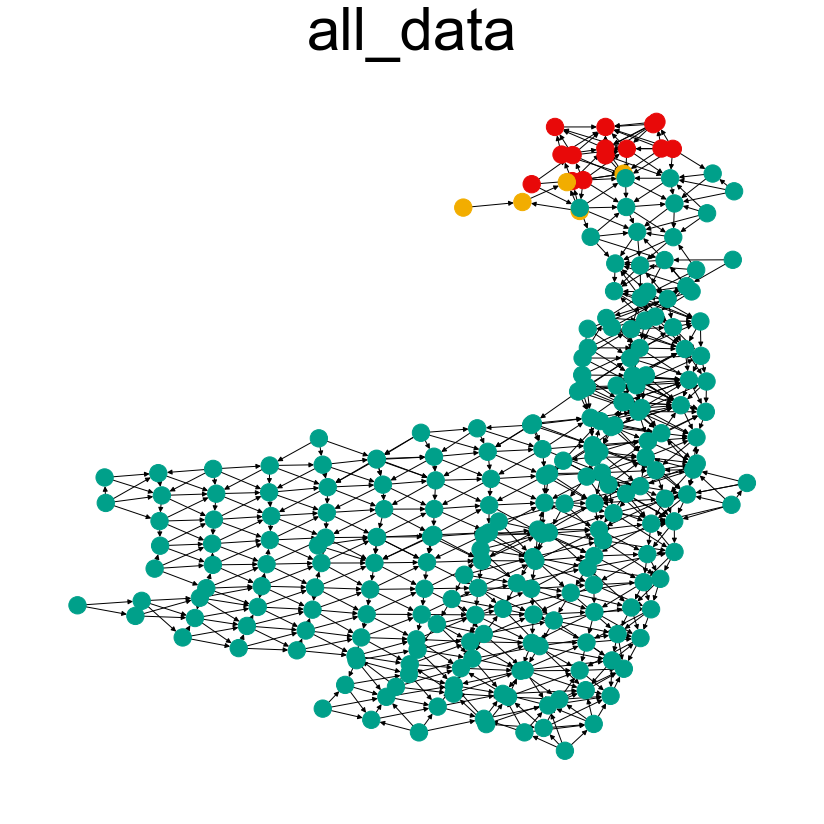

In [79]:
filepath = "all_data.png"
draw_graph(scomplex, filepath, with_labels = False)
append_states(scomplex, largestShape, X)

## Make state columns

When the states are appended to the dataframe, it creates a dummy column for each state. The state is name by the node id of the local maximum associated with that state. The next few blocks of code do the following:

1. Rename the state columns as "State 1", "State 2", etc.
2. Create a "STATE" column that has number values determined by which states the observation lies in. This will be used so that we can color the html by all states at once:
   * Only one state: {"State 1" = 1/3, "State 2" = 2/3, "State 3" = 1}
   * Two states : {"State 1 & 2" = 1/2, "State 2 & 3" = 5/6}
   * All or none states : {0}
3. To color by all states at once, we will need to use the median node coloring. In order to make it so each node is colored entirely by one state, we need to alter a few observation values to skew the median to color the node by the associated state color. These skewed values will be stored in a new column called "STATE_color"

In [85]:
X = X.rename(columns = {"cube60_cluster0": "State 1", 
                        "cube756_cluster0": "State 3", 
                        "cube665_cluster0": "State 2"})

X["STATE"] = 0
X["STATE"] = np.where(X['State 1'] == 1, 1/3, X["STATE"])
X["STATE"] = np.where(X['State 2'] == 1, 2/3, X["STATE"])
X["STATE"] = np.where(X['State 3'] == 1, 1, X["STATE"])
X["STATE"] = np.where((X['State 1'] == 1) & (X['State 2'] == 1), 1/2, X["STATE"])
X["STATE"] = np.where((X['State 3'] == 1) & (X['State 2'] == 1), 5/6, X["STATE"])
X["STATE"] = np.where((X['State 3'] == 1) & (X['State 2'] == 1) & (X['State 3'] == 1), 0, X["STATE"])

# Adjust state column for coloring
X['STATE_color'] = X['STATE']
X["STATE_color"][52996] = 2/3
X["STATE_color"][55565] = 2/3
X["STATE_color"][55589] = 2/3

Saving scomplex and the data.

This will save the scomplex and the associated dataframe to a pickle file so that it may be referenced later on without having to rerun the entire file.

In [86]:
scomplex_dict = {}
dfs_dict = {}

scomplex_dict["LTRM"] = scomplex
dfs_dict["LTRM"] = X

pickle = pk.dump(scomplex_dict, open("LTRM_scomplex.p", "wb"))
pickle = pk.dump(dfs_dict, open("LTRM_df.p", "wb"))

# Scomplex coloring

## Get coloring names lists

These are created for the purpose of passing in a list of coloring values into the mapper function. To pass in the coloring values to the coloring function, use "X[name_list]". To pass in the coloring names use "names_list".

In [36]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

continuous_variable_colors =  ["WDP_color", "SECCHI_color", "TEMP_color", "DO_color", 
                                "TURB_color", "VEL_color", "TP_color", "TN_color", 
                                "SS_color", "CHLcal_color"]

pool_names = ['Unexploded Ordinance Area - Pool 13',
              'Bellevue, IA',
              'Brighton, IL',
              'Havana, IL',
              'Jackson, MO',
              'Lake City, MN',
              'Onalaska, WI']

decade_names = ['1993-2000', '1898-2004', '2001-2013', '2010-2016', '2014-2020']

stratum_names = ['Backwater area contiguous to the main channel',
                'Impounded',
                'Isolated',
                'Lake Pepin or Swan Lake',
                'Main channel',
                'Side channel']

state_names = ['State 1', 'State 2', 'State 3']

## Color the scomplex html

To change what the html is colored by, change the color_vals and color_names to be whichever list of variables you want to color by. Note that for the continuous variables, there is different coloring columns. Also be sure to change the html file name.

In [ ]:
# if using the pickle file data, run the following code
X = df

In [ ]:
summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

y = np.array(X[continuous_variables])

# Make HTML with color values as the continous variables
color_vals = X[continuous_variable_colors]
color_names = continuous_variables
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                 color_values = color_vals,
                                                                 color_function_name = color_names)


html_output_path = 'LTRM_water_quality_variables.html'
    
mapper.visualize(scomplex, color_values = color_vals, color_function_name = color_names, 
                path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables, 
                custom_tooltips = y, node_color_function = ["mean", "std", "median", "max"])


## Get continuous variable boxplots for each state

In [ ]:
# Make different dataframes for the observations in each state - use df if using pickle file
state1 = X[X['State 1'] == 1]
state2 = X[X['State 2'] == 1]
state3 = X[X['State 3'] == 1]

### Scaled Boxplots

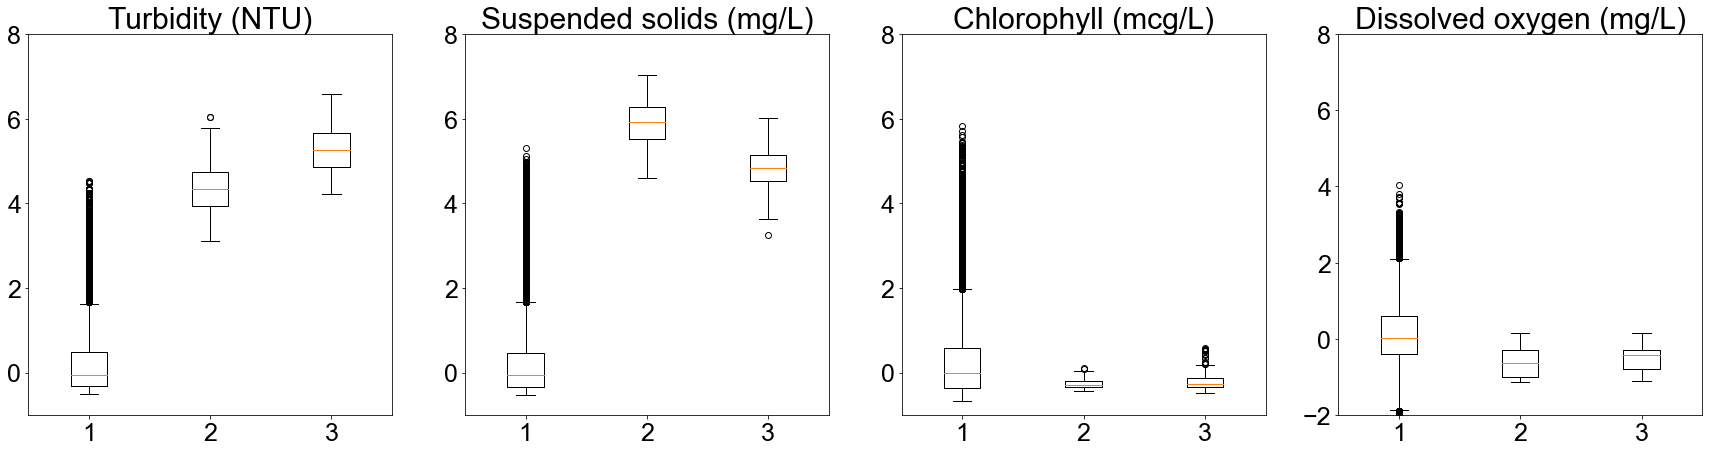

In [89]:
plt.rcParams.update({'font.size': 25})
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor']= 'white'
plt.rcParams['font.sans-serif'] = "Arial"
#plt.rcParams["font.family"] = "arial"
 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols = 4, figsize = (30, 7))

bp1 = ax1.boxplot([state1['TURB'], state3['TURB'],state2['TURB']],
                    vert = True,
                    labels = ['1', '2','3'])
ax1.set_title('Turbidity (NTU)')   
ax1.set_ylim(-1, 8)               


bp2 = ax2.boxplot([state1['SS'], state2['SS'],state3['SS']],
                    vert = True,
                    labels = ['1', '2','3'])
ax2.set_title('Suspended solids (mg/L)')   
ax2.set_ylim(-1, 8) 

bp3 = ax3.boxplot([state1['CHLcal'], state2['CHLcal'],state3['CHLcal']],
                    vert = True,
                    labels = ['1', '2','3'])
ax3.set_title('Chlorophyll (mcg/L)')   
ax3.set_ylim(-1, 8) 

bp4 = ax4.boxplot([state1['DO'], state2['DO'],state3['DO']],
                    vert = True,
                    labels = ['1', '2','3'])
ax4.set_title('Dissolved oxygen (mg/L)')   
ax4.set_ylim(-2, 8) 

plt.savefig('boxplots_alldata_scaled.png')

### Inverse robust scaled boxplots

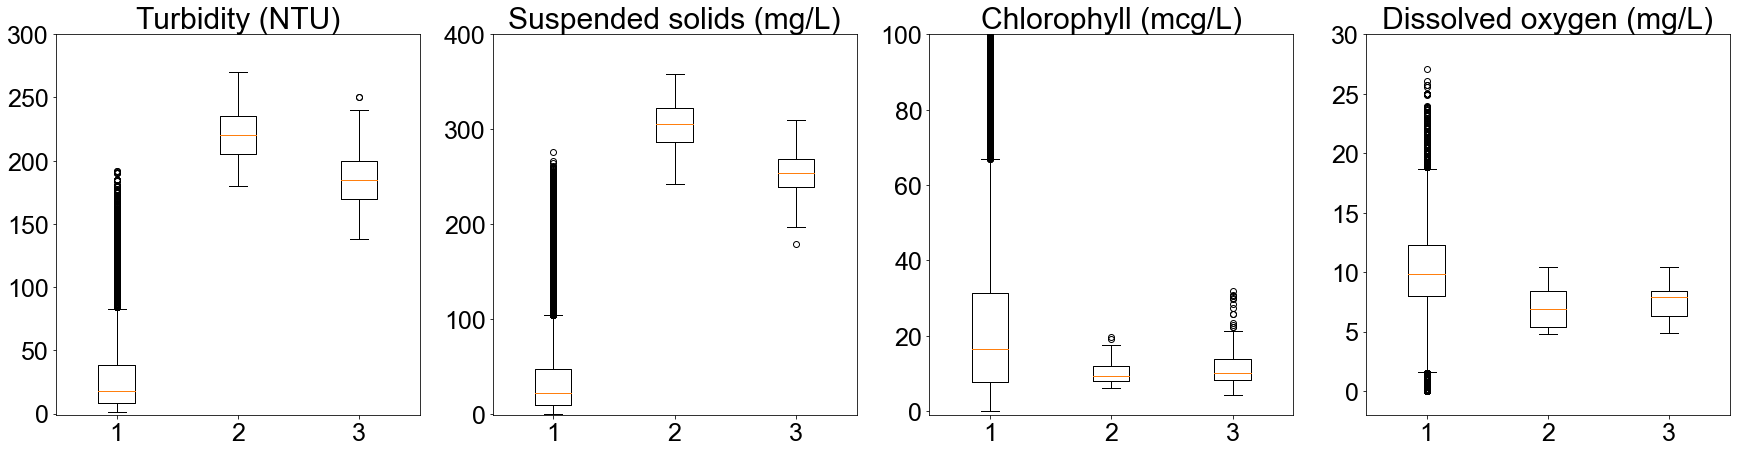

In [91]:
plt.rcParams.update({'font.size': 26})
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor']= 'white'
plt.rcParams['font.sans-serif'] = "Arial"
 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols = 4, figsize = (30, 7))

bp1 = ax1.boxplot([state1['TURB_unscaled'], state2['TURB_unscaled'],state3['TURB_unscaled']],
                    vert = True,
                    labels = ['1', '2','3'])
ax1.set_title('Turbidity (NTU)')   
ax1.set_ylim(-1, 300)               

bp2 = ax2.boxplot([state1['SS_unscaled'], state2['SS_unscaled'],state3['SS_unscaled']],
                    vert = True,
                    labels = ['1', '2','3'])
ax2.set_title('Suspended solids (mg/L)')   
ax2.set_ylim(-1, 400) 

bp3 = ax3.boxplot([state1['CHLcal_unscaled'], state2['CHLcal_unscaled'],state3['CHLcal_unscaled']],
                    vert = True,
                    labels = ['1', '2','3'])
ax3.set_title('Chlorophyll (mcg/L)')   
ax3.set_ylim(-1, 100) 

bp4 = ax4.boxplot([state1['DO_unscaled'], state2['DO_unscaled'],state3['DO_unscaled']],
                    vert = True,
                    labels = ['1', '2','3'])
ax4.set_title('Dissolved oxygen (mg/L)')   
ax4.set_ylim(-2, 30) 


plt.savefig('boxplots_alldata_unscaled.png')